# COM6509 Assignment 2


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from sklearn import metrics
import seaborn as sns
import pandas as pd 
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## B1. Reproducibility & readability [2 marks]

Using my UCard number as the random seed for reproducibility.

In [2]:
# Set random seed for numpy
np.random.seed(1746534)
# Set random seed for pytorch
torch.manual_seed(1746534)
# Set random seed for pytorch running in GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1746534)

## B2. Supervised learning on Fashion-MNIST [16 marks]
### B2.1 Data loading and inspection [2 marks]
### a) Use the PyTorch API for Fashion-MNIST to load both the training and test data of Fashion-MNIST. You may refer to similar procedures in Lab 7 for CIFAR-10. Preprocessing is NOT required but you are encouraged to explore and use preprocessing such as those in the torchvision.transforms API . [1 mark]

In [3]:
batchSize=512
# Preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Load the training data
trainset = datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=0)
# Load the test data
testset = datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, 
                                         shuffle=False, num_workers=0)
# Define classes name
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle_boot')
# Get some random training images(256)
dataiter = trainloader.__iter__()
images, labels = dataiter.next()
# Get some random testing images(256)
test_dataiter = testloader.__iter__()
test_images, test_labels = test_dataiter.next()
# Functions to show an image
def imageshow(img):
    img = img / 2 + 0.5 # unnormalize back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #rearrange dimensions to numpy format for disply
    plt.show()

### b) Display at least eight images for each of the 10 classes (8x10=80 images). [1 mark]

T-shirt/top


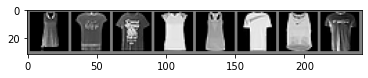

Trouser


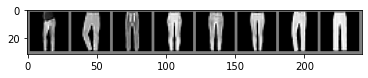

Pullover


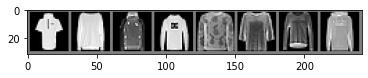

Dress


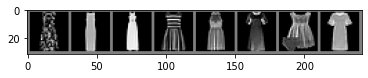

Coat


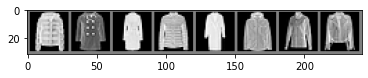

Sandal


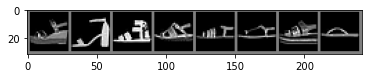

Shirt


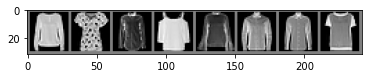

Sneaker


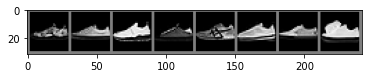

Bag


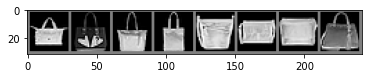

Ankle_boot


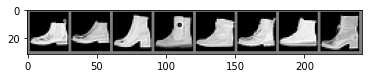

In [4]:
# Initialization imagelist and number of images of each class
imagelist0 = []; imagelist1 = []; imagelist2 = []; imagelist3 = []; imagelist4 = []
imagelist5 = []; imagelist6 = []; imagelist7 = []; imagelist8 = []; imagelist9 = []
num_class0 = 0; num_class1 = 0; num_class2 = 0; num_class3 = 0; num_class4 = 0
num_class5 = 0; num_class6 = 0; num_class7 = 0; num_class8 = 0; num_class9 = 0
# Put different kinds of images into lists.
for i in range(256):    
    if labels[i] == 0 and num_class0 < 8:
        imagelist0.append(images[i]); num_class0 = num_class0 + 1
    elif labels[i] == 1 and num_class1 < 8:
        imagelist1.append(images[i]); num_class1 = num_class1 + 1
    elif labels[i] == 2 and num_class2 < 8:
        imagelist2.append(images[i]); num_class2 = num_class2 + 1
    elif labels[i] == 3 and num_class3 < 8:
        imagelist3.append(images[i]); num_class3 = num_class3 + 1
    elif labels[i] == 4 and num_class4 < 8:
        imagelist4.append(images[i]); num_class4 = num_class4 + 1
    elif labels[i] == 5 and num_class5 < 8:
        imagelist5.append(images[i]); num_class5 = num_class5 + 1
    elif labels[i] == 6 and num_class6 < 8:
        imagelist6.append(images[i]); num_class6 = num_class6 + 1
    elif labels[i] == 7 and num_class7 < 8:
        imagelist7.append(images[i]); num_class7 = num_class7 + 1
    elif labels[i] == 8 and num_class8 < 8:
        imagelist8.append(images[i]); num_class8 = num_class8 + 1
    elif labels[i] == 9 and num_class9 < 8:
        imagelist9.append(images[i]); num_class9 = num_class9 + 1
# Display all images.
print('T-shirt/top'); imageshow(torchvision.utils.make_grid(imagelist0))
print('Trouser'); imageshow(torchvision.utils.make_grid(imagelist1))
print('Pullover'); imageshow(torchvision.utils.make_grid(imagelist2))
print('Dress'); imageshow(torchvision.utils.make_grid(imagelist3))
print('Coat'); imageshow(torchvision.utils.make_grid(imagelist4))
print('Sandal'); imageshow(torchvision.utils.make_grid(imagelist5))
print('Shirt'); imageshow(torchvision.utils.make_grid(imagelist6))
print('Sneaker'); imageshow(torchvision.utils.make_grid(imagelist7))
print('Bag'); imageshow(torchvision.utils.make_grid(imagelist8))
print('Ankle_boot'); imageshow(torchvision.utils.make_grid(imagelist9))

### B2.2 Evaluation metrics [2 marks]

The following 4 functions are used to record M1, M2, M4 and confusion matrix in B2.3.

The codes for recording M3(Training time) will be displayed directly in the cell of the training models.

In [5]:
# M1 in B2.3
def test_accuracy_B23(model_x, test_i, test_l):
    test_correct = 0
    test_total = 0
    
    test_i = test_i.view(-1, 28*28).to(device)
    test_outputs = model_x(test_i)
    _, test_predicted = torch.max(test_outputs.data, 1) #
    test_total += test_l.size(0)
    if torch.cuda.is_available():
        test_correct += (test_predicted.cpu() == test_l.cpu()).sum()
    else:
        test_correct += (test_predicted == test_l).sum()
    test_accuracy = 100 * test_correct.item() / test_total
    print('Testing_Accuracy is: %s%%' % test_accuracy)
    return test_accuracy
# M2 in B2.3    
def train_accuracy_B23(model_x, train_i, train_l):
    train_correct = 0
    train_total = 0

    train_i = train_i.view(-1, 28*28).to(device)
    train_outputs = model_x(train_i)
    _, train_predicted = torch.max(train_outputs.data, 1)
    train_total += train_l.size(0)
    if torch.cuda.is_available():
        train_correct += (train_predicted.cpu() == train_l.cpu()).sum()
    else:
        train_correct += (train_predicted == train_l).sum()
    train_accuracy = 100 * train_correct.item() / train_total
    print('Training_Accuracy is: %s%%' % train_accuracy)
    return train_accuracy
# M4 in B2.3    
def learnable_params_B23(model_x):
    pytorch_total_params = sum(p.numel() for p in model_x.parameters() if p.requires_grad)
    print('The number of learnable parameters is: {}'.format(pytorch_total_params))
    return pytorch_total_params
# Confusion_Matrix in B2.3    
def confusion_matrix_B23(model_x, test_i, test_l):
    test_i = test_i.view(-1, 28*28).to(device)
    test_outputs = model_x(test_i)
    _, test_predicted = torch.max(test_outputs.data, 1)
    cm = metrics.confusion_matrix(test_l, test_predicted.cpu())
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

### B2.3 Logistic regression [4 marks]

In [6]:
# Create the logistic regression module
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

#### a) Train a logistic regression model on the training set of Fashion-MNIST and test the trained model on the test set of Fashion-MNIST. Report the four metrics M1 to M 4 and plot a confusion matrix for predictions on the test data. [2 marks]

Report of the four metrics M1 to M 4 and the plot of a confusion matrix for predictions on the test data of B2.3a can be seen in the following output.

Training time of B2.3a is 368300.71875 ms
Testing_Accuracy is: 80.859375%
Training_Accuracy is: 78.90625%
The number of learnable parameters is: 7850


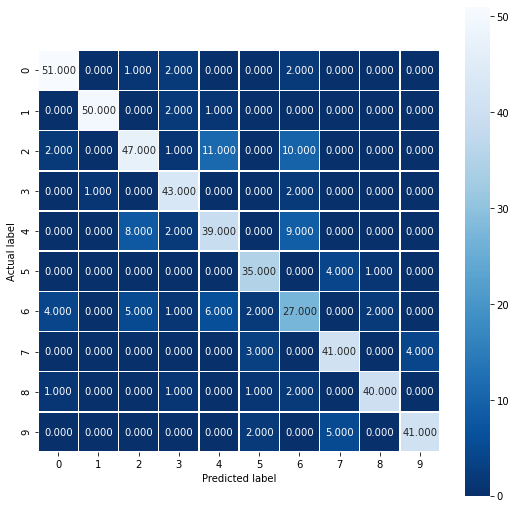

In [7]:
epochs_23a = 30
input_dim = 784
output_dim = 10
lr_rate = 0.001

model_23a = LogisticRegression(input_dim, output_dim)
criterion_23a = torch.nn.CrossEntropyLoss()
optimizer_23a = torch.optim.SGD(model_23a.parameters(), lr=lr_rate)
# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_23a.to(device)
# Start training time record
start_23a = torch.cuda.Event(enable_timing=True)
end_23a = torch.cuda.Event(enable_timing=True)
start_23a.record()
for epoch in range(int(epochs_23a)):
    for i, (images_23a, labels_23a) in enumerate(trainloader):
        images_23a = Variable(images_23a.view(-1, 28 * 28)).to(device)
        labels_23a = Variable(labels_23a).to(device)
        
        optimizer_23a.zero_grad()
        outputs_23a = model_23a(images_23a)
        loss_23a = criterion_23a(outputs_23a, labels_23a)
        loss_23a.backward(retain_graph=True)
        optimizer_23a.step()
        
# Finish training time record
end_23a.record()
torch.cuda.synchronize()
print("Training time of B2.3a is", start_23a.elapsed_time(end_23a), "ms")
test_accuracy_23a = test_accuracy_B23(model_23a, test_images, test_labels)
train_accuracy_23a = train_accuracy_B23(model_23a, images, labels)
learnable_params_23a = learnable_params_B23(model_23a)
confusion_matrix_B23(model_23a, test_images, test_labels)

#### b) Train and test a logistic regression model with L1 regularisation as in a). Report M1 to M4 and plot a confusion matrix for predictions on the test data [1 mark]

Report of the four metrics M1 to M 4 and the plot of a confusion matrix for predictions on the test data of B2.3b can be seen in the following output.

Training time of B2.3b is 355395.90625 ms
Testing_Accuracy is: 76.953125%
Training_Accuracy is: 74.8046875%
The number of learnable parameters is: 7850


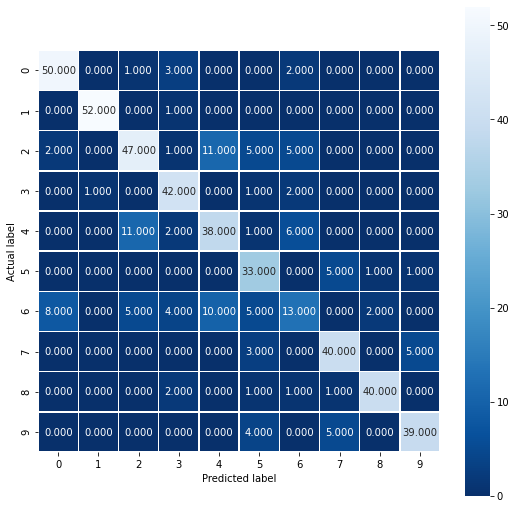

In [8]:
epochs_23b = 30
input_dim = 784
output_dim = 10
lr_rate = 0.001

model_23b = LogisticRegression(input_dim, output_dim)
criterion_23b = torch.nn.CrossEntropyLoss()
optimizer_23b = torch.optim.SGD(model_23b.parameters(), lr=lr_rate)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_23b.to(device)
# L1 parameter
l1_lambda = 0.01

start_23b = torch.cuda.Event(enable_timing=True)
end_23b = torch.cuda.Event(enable_timing=True)
start_23b.record()
for epoch in range(int(epochs_23b)):
    for i, (images_23b, labels_23b) in enumerate(trainloader):
        images_23b = Variable(images_23b.view(-1, 28 * 28)).to(device)
        labels_23b = Variable(labels_23b).to(device)
        optimizer_23b.zero_grad()
        outputs_23b = model_23b(images_23b)
        
        loss_23b = criterion_23b(outputs_23b, labels_23b)
        l1_regularization = 0
        for param_23b in model_23b.parameters():
            l1_regularization =  l1_regularization + param_23b.abs().sum()
        # L1 regularization    
        loss_23b = loss_23b +  l1_lambda * l1_regularization
        loss_23b.backward()
        optimizer_23b.step()        

end_23b.record()
torch.cuda.synchronize()
print("Training time of B2.3b is", start_23b.elapsed_time(end_23b), "ms")
test_accuracy_23b = test_accuracy_B23(model_23b, test_images, test_labels)
train_accuracy_23b = train_accuracy_B23(model_23b, images, labels)
learnable_params_23b = learnable_params_B23(model_23b)
confusion_matrix_B23(model_23b, test_images, test_labels)

#### c) Train and test a logistic regression model with L2 regularisation as in a). Report M1 to M4 and plot a confusion matrix for predictions on the test data [1 mark]

Report of the four metrics M1 to M 4 and the plot of a confusion matrix for predictions on the test data of B2.3c can be seen in the following output.

Training time of B2.3c is 349406.75 ms
Testing_Accuracy is: 80.2734375%
Training_Accuracy is: 77.9296875%
The number of learnable parameters is: 7850


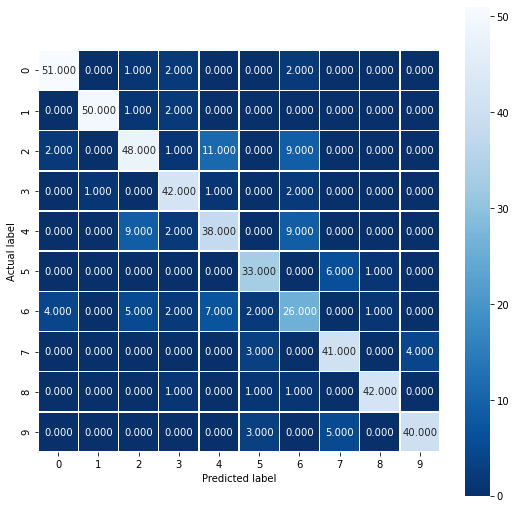

In [9]:
epochs_23c = 30
input_dim = 784
output_dim = 10
lr_rate = 0.001

model_23c = LogisticRegression(input_dim, output_dim)
criterion_23c = torch.nn.CrossEntropyLoss()
optimizer_23c = torch.optim.SGD(model_23c.parameters(), lr=lr_rate)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_23c.to(device)
# L2 parameter
l2_lambda = 0.01

start_23c = torch.cuda.Event(enable_timing=True)
end_23c = torch.cuda.Event(enable_timing=True)
start_23c.record()
for epoch in range(int(epochs_23c)):
    for i, (images_23c, labels_23c) in enumerate(trainloader):
        images_23c = Variable(images_23c.view(-1, 28 * 28)).to(device)
        labels_23c = Variable(labels_23c).to(device)
        optimizer_23c.zero_grad()
        outputs_23c = model_23c(images_23c)
        
        loss_23c = criterion_23c(outputs_23c, labels_23c)
        l2_regularization = 0
        for param_23c in model_23c.parameters():
            l2_regularization =  l2_regularization + 0.5 * (param_23c ** 2).sum()
        # L2 regularization        
        loss_23c = loss_23c +  l2_lambda * l2_regularization
        loss_23c.backward()
        optimizer_23c.step()        

end_23c.record()
torch.cuda.synchronize()
print("Training time of B2.3c is", start_23c.elapsed_time(end_23c), "ms")
test_accuracy_23c = test_accuracy_B23(model_23c, test_images, test_labels)
train_accuracy_23c = train_accuracy_B23(model_23c, images, labels)
learnable_params_23c = learnable_params_B23(model_23c)
confusion_matrix_B23(model_23c, test_images, test_labels)

### B2.4 Convolutional Neural networks (6 marks)

The following 4 functions are used to record M1, M2, M4 and confusion matrix in B2.4.

The codes for recording M3(Training time) will be displayed directly in the cell of the training models.

In [10]:
def test_accuracy_B24(model_x, test_i, test_l):
    test_correct = 0
    test_total = 0
    
    test_i = test_i.to(device)
    test_outputs = model_x(test_i)
    _, test_predicted = torch.max(test_outputs.data, 1) #
    test_total += test_l.size(0)
    if torch.cuda.is_available():
        test_correct += (test_predicted.cpu() == test_l.cpu()).sum()
    else:
        test_correct += (test_predicted == test_l).sum()
    test_accuracy = 100 * test_correct.item() / test_total
    print('Testing_Accuracy is: %s%%' % test_accuracy)
    return test_accuracy
    
def train_accuracy_B24(model_x, train_i, train_l):
    train_correct = 0
    train_total = 0

    train_i = train_i.to(device)
    train_outputs = model_x(train_i)
    _, train_predicted = torch.max(train_outputs.data, 1)
    train_total += train_l.size(0)
    if torch.cuda.is_available():
        train_correct += (train_predicted.cpu() == train_l.cpu()).sum()
    else:
        train_correct += (train_predicted == train_l).sum()
    train_accuracy = 100 * train_correct.item() / train_total
    print('Training_Accuracy is: %s%%' % train_accuracy)
    return train_accuracy
    
def learnable_params_B24(model_x):
    pytorch_total_params = sum(p.numel() for p in model_x.parameters() if p.requires_grad)
    print('The number of learnable parameters is: {}'.format(pytorch_total_params))
    return pytorch_total_params
    
def confusion_matrix_B24(model_x, test_i, test_l):
    test_i = test_i.to(device)
    test_outputs = model_x(test_i)
    _, test_predicted = torch.max(test_outputs.data, 1)
    cm = metrics.confusion_matrix(test_l, test_predicted.cpu())
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

#### a) Design a CNN with two Conv layers and two FC layers. Train and test it as in B2.3a. Report M1 to M4 and plot a confusion matrix for predictions on the test data. [2 marks]

In [11]:
# Create the CNN module with two Conv layers and two FC layers
class CNN_24a(nn.Module):
    def __init__(self):
        super(CNN_24a, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) #1: #input channels; 16: #output channels; 5: kernel size , padding=2
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 12 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Report of the four metrics M1 to M 4 and the plot of a confusion matrix for predictions on the test data of B2.4a can be seen in the following output.

Training time of B2.4a is 352607.53125 ms
Testing_Accuracy is: 89.2578125%
Training_Accuracy is: 92.1875%
The number of learnable parameters is: 22278


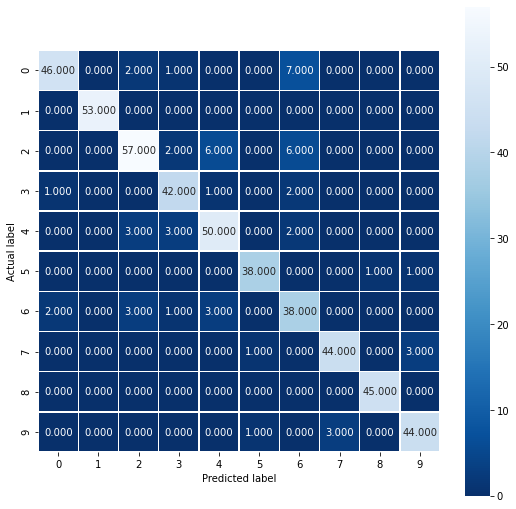

In [12]:
epochs_24a = 30
lr_rate = 0.1
momentum_value = 0.9

model_24a = CNN_24a()
criterion_24a = nn.CrossEntropyLoss()
optimizer_24a = optim.SGD(model_24a.parameters(), lr = lr_rate, momentum = momentum_value)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_24a.to(device)

start_24a = torch.cuda.Event(enable_timing=True)
end_24a = torch.cuda.Event(enable_timing=True)
start_24a.record()
for epoch in range(int(epochs_24a)):
    for i, (images_24a, labels_24a) in enumerate(trainloader, 0):
        images_24a = images_24a.to(device)
        labels_24a = labels_24a.to(device)
        optimizer_24a.zero_grad()

        outputs_24a = model_24a(images_24a)
        loss_24a = criterion_24a(outputs_24a, labels_24a)
        loss_24a.backward()
        optimizer_24a.step()

end_24a.record()
torch.cuda.synchronize()
print("Training time of B2.4a is", start_24a.elapsed_time(end_24a), "ms")
test_accuracy_24a = test_accuracy_B24(model_24a, test_images, test_labels)
train_accuracy_24a = train_accuracy_B24(model_24a, images, labels)
learnable_params_24a = learnable_params_B24(model_24a)
confusion_matrix_B24(model_24a, test_images, test_labels)

#### b) Design a CNN with two Conv layers and five FC layers. Train and test it as in B2.3a. Report M1 to M4 and plot a confusion matrix for predictions on the test data. [2 marks]

In [13]:
# Create the CNN module with two Conv layers and five FC layers
class CNN_24b(nn.Module):
    def __init__(self):
        super(CNN_24b, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 160)
        self.fc2 = nn.Linear(160, 130)
        self.fc3 = nn.Linear(130, 90)
        self.fc4 = nn.Linear(90, 60)
        self.fc5 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 12 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

Report of the four metrics M1 to M 4 and the plot of a confusion matrix for predictions on the test data of B2.4b can be seen in the following output.

Training time of B2.4b is 326772.78125 ms
Testing_Accuracy is: 89.84375%
Training_Accuracy is: 90.8203125%
The number of learnable parameters is: 71638


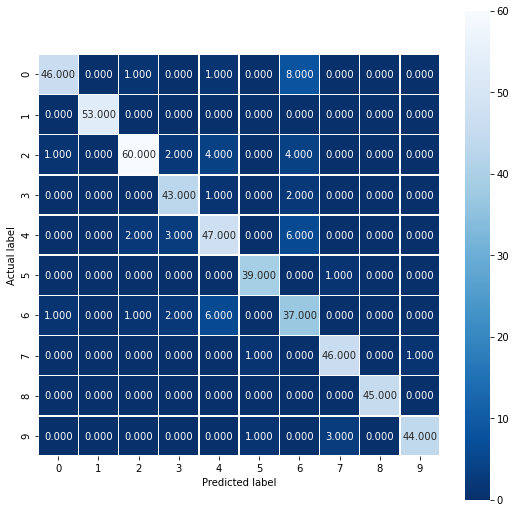

In [14]:
epochs_24b = 30
lr_rate = 0.1
momentum_value = 0.9

model_24b = CNN_24b()
criterion_24b = nn.CrossEntropyLoss()
optimizer_24b = optim.SGD(model_24b.parameters(), lr = lr_rate, momentum = momentum_value)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_24b.to(device)

start_24b = torch.cuda.Event(enable_timing=True)
end_24b = torch.cuda.Event(enable_timing=True)
start_24b.record()

for epoch in range(int(epochs_24b)):
    for i, (images_24b, labels_24b) in enumerate(trainloader, 0):
        images_24b = images_24b.to(device)
        labels_24b = labels_24b.to(device)
        optimizer_24b.zero_grad()

        outputs_24b = model_24b(images_24b)
        loss_24b = criterion_24b(outputs_24b, labels_24b)
        loss_24b.backward()
        optimizer_24b.step()

end_24b.record()
torch.cuda.synchronize()
print("Training time of B2.4b is", start_24b.elapsed_time(end_24b), "ms")
test_accuracy_24b = test_accuracy_B24(model_24b, test_images, test_labels)
train_accuracy_24b = train_accuracy_B24(model_24b, images, labels)
learnable_params_24b = learnable_params_B24(model_24b)
confusion_matrix_B24(model_24b, test_images, test_labels)

#### c) Design a CNN with five Conv layers and two FC layers. Train and test it as in B2.3a. Report M1 to M4 and plot a confusion matrix for predictions on the test data. [2 marks]

In [15]:
# Create the CNN module with five Conv layers and five FC layers
class CNN_24c(nn.Module):
    def __init__(self):
        super(CNN_24c, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 24, 3, padding=1)
        self.conv4 = nn.Conv2d(24, 24, 3, padding=1)        
        self.conv5 = nn.Conv2d(24, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(F.relu(self.conv5(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Report of the four metrics M1 to M 4 and the plot of a confusion matrix for predictions on the test data of B2.4c can be seen in the following output.

Training time of B2.4c is 371623.15625 ms
Testing_Accuracy is: 91.796875%
Training_Accuracy is: 94.3359375%
The number of learnable parameters is: 1072202


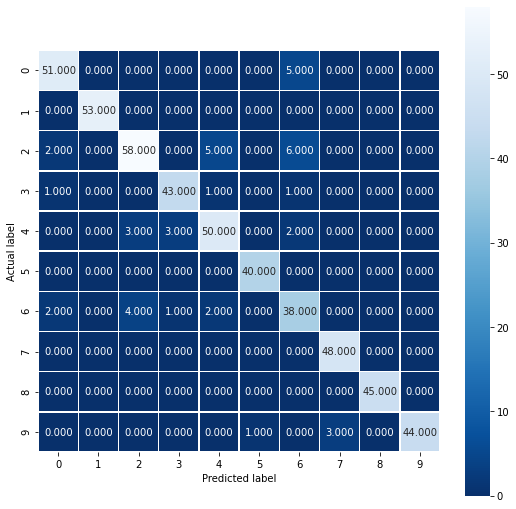

In [16]:
epochs_24c = 30
lr_rate = 0.01
momentum_value = 0.9

model_24c = CNN_24c()
criterion_24c = nn.CrossEntropyLoss()
optimizer_24c = optim.SGD(model_24c.parameters(), lr = lr_rate, momentum = momentum_value)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_24c.to(device)

start_24c = torch.cuda.Event(enable_timing=True)
end_24c = torch.cuda.Event(enable_timing=True)
start_24c.record()

for epoch in range(int(epochs_24c)):
    for i, (images_24c, labels_24c) in enumerate(trainloader, 0):
        images_24c = images_24c.to(device)
        labels_24c = labels_24c.to(device)
        optimizer_24c.zero_grad()

        outputs_24c = model_24c(images_24c)
        loss_24c = criterion_24c(outputs_24c, labels_24c)
        loss_24c.backward()
        optimizer_24c.step()

end_24c.record()
torch.cuda.synchronize()
print("Training time of B2.4c is", start_24c.elapsed_time(end_24c), "ms")
test_accuracy_24c = test_accuracy_B24(model_24c, test_images, test_labels)
train_accuracy_24c = train_accuracy_B24(model_24c, images, labels)
learnable_params_24c = learnable_params_B24(model_24c)
confusion_matrix_B24(model_24c, test_images, test_labels)

### B2.5 Performance comparison (2 marks)
#### Summarise each of the four metrics from the six models in B2.3 and B2.4 using a bar graph. In total, four bar graphs need to be generated and displayed, one for each metric with six results from B2.3 and B2.4. [1 mark]

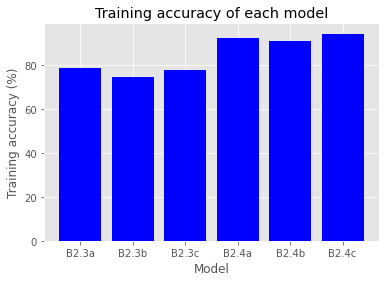

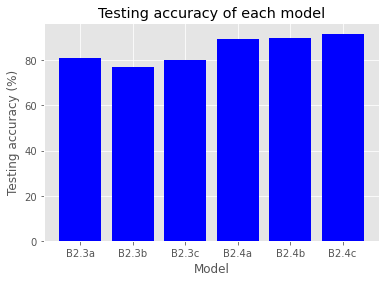

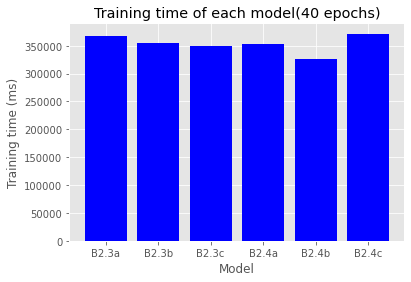

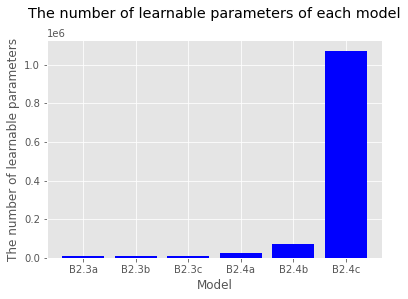

In [17]:
plt.style.use('ggplot')
# Set name of x-axis labels 
x = ['B2.3a', 'B2.3b', 'B2.3c', 'B2.4a', 'B2.4b', 'B2.4c']
# Set name of four y-axis labels
energy1 = [train_accuracy_23a, train_accuracy_23b, train_accuracy_23c, train_accuracy_24a, train_accuracy_24b, train_accuracy_24c]
energy2 = [test_accuracy_23a, test_accuracy_23b, test_accuracy_23c, test_accuracy_24a, test_accuracy_24b, test_accuracy_24c]
energy3 = [start_23a.elapsed_time(end_23a), start_23b.elapsed_time(end_23b), start_23c.elapsed_time(end_23c), 
           start_24a.elapsed_time(end_24a), start_24b.elapsed_time(end_24b), start_24c.elapsed_time(end_24c)]
energy4 = [learnable_params_23a, learnable_params_23b, learnable_params_23c, 
           learnable_params_24a, learnable_params_24b, learnable_params_24c]
x_pos = [i for i, _ in enumerate(x)]
# Graph of six results of training accuracy
plt.bar(x_pos, energy1, color='blue')
plt.xlabel("Model")
plt.ylabel("Training accuracy (%)")
plt.title("Training accuracy of each model")
#Set the current tick locations and labels of the x-axis.
plt.xticks(x_pos, x)
plt.show()
# Graph of six results of testing accuracy
plt.bar(x_pos, energy2, color='blue')
plt.xlabel("Model")
plt.ylabel("Testing accuracy (%)")
plt.title("Testing accuracy of each model")
plt.xticks(x_pos, x)
plt.show()
# Graph of six results of training time
plt.bar(x_pos, energy3, color='blue')
plt.xlabel("Model")
plt.ylabel("Training time (ms)")
plt.title("Training time of each model(40 epochs)")
plt.xticks(x_pos, x)
plt.show()
# Graph of six results of the number of learnable parameters
plt.bar(x_pos, energy4, color='blue')
plt.xlabel("Model")
plt.ylabel("The number of learnable parameters")
plt.title("The number of learnable parameters of each model\n")
plt.xticks(x_pos, x)
plt.show()

#### Describe at least two observations interesting to you. [1 mark]

1. For the logistic regression model trained through the data set in this assignment, the performance of the model using L2 regularization on the training set and the test set is better than the model using L1 regularization.
2. The performance of the trained convolutional neural network model on the training set and test set is better than that of the logistic regression model.
3. In convolutional neural network model, the increase in the number of convolutional layers and the increase in the number of fully connected layers will increase the number of learnable parameters. In comparison, the number of convolutional layers has a very very large impact on the number of parameters.

## B3. Unsupervised learning on Fashion-MNIST [12 marks]
### B3.1 PCA and k -means [7 marks]

First, I prepare the data set of two classes: Trouser, Pullover.

In [18]:
# Convert tensor to array
train_set_array = trainset.data.numpy()
train_set_array_targets = trainset.targets.numpy()
# Convert 3darray to 2darray
train_set_array_2d = train_set_array.reshape(60000, 784)
# Convert 2darray to dataframe, including all 10 classes
train_set_features_all = pd.DataFrame(train_set_array_2d)
train_set_labels_all = pd.DataFrame(train_set_array_targets)
# Change column name of labels
train_set_labels_all = train_set_labels_all.rename(columns={0 : "label"})
# Concatenate features and labels
train_set_all = pd.concat([train_set_features_all, train_set_labels_all], axis = 1)
# Filter out the required data from the whole data set
train_set_2class = train_set_all[train_set_all['label'].isin([1, 2])]

Remember the row numbers of the first 15 Trousers and Pullovers, and use them later in B3.1b).

In [19]:
train_set_2class.head(40)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
5,0,0,0,0,1,0,0,0,0,22,...,0,0,0,133,167,73,0,0,0,2
7,0,0,0,0,0,1,1,0,0,0,...,0,3,0,82,237,231,70,0,0,2
16,0,0,0,0,0,0,0,0,0,53,...,188,107,0,0,0,0,0,0,0,1
21,0,0,0,0,0,0,0,0,9,0,...,7,0,0,0,0,0,0,0,0,1
27,0,0,0,1,0,0,0,0,0,70,...,5,0,14,158,147,0,0,0,0,2
37,0,0,1,1,0,1,0,0,0,0,...,0,0,0,20,55,59,17,0,0,2
38,0,0,0,0,0,0,0,0,0,13,...,0,0,0,0,0,0,0,0,0,1
45,0,0,0,1,0,0,0,0,0,34,...,0,0,0,0,0,0,0,0,0,2
53,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
54,0,0,0,0,0,0,0,0,0,0,...,0,0,86,118,67,0,0,0,0,2


### a) Apply PCA to all images of these two chosen classes. Visualise the top 24 eigenvectors as images and display them in the order of descending corresponding values (the one corresponding to the largest eigenvalue first). [2 marks]

In [20]:
train_set_labels = train_set_2class[['label']].iloc[:, :]
train_set_features = train_set_2class.iloc[:, 0:784]
# Normalizing the features
input_train_set_features = train_set_features/255
# Get top 24 eigenvectors
pca = PCA(n_components=24)
input_train_set_features_r = pca.fit(input_train_set_features).transform(input_train_set_features)

Visualise the top 24 eigenvectors as images and display them in the order of descending corresponding values.

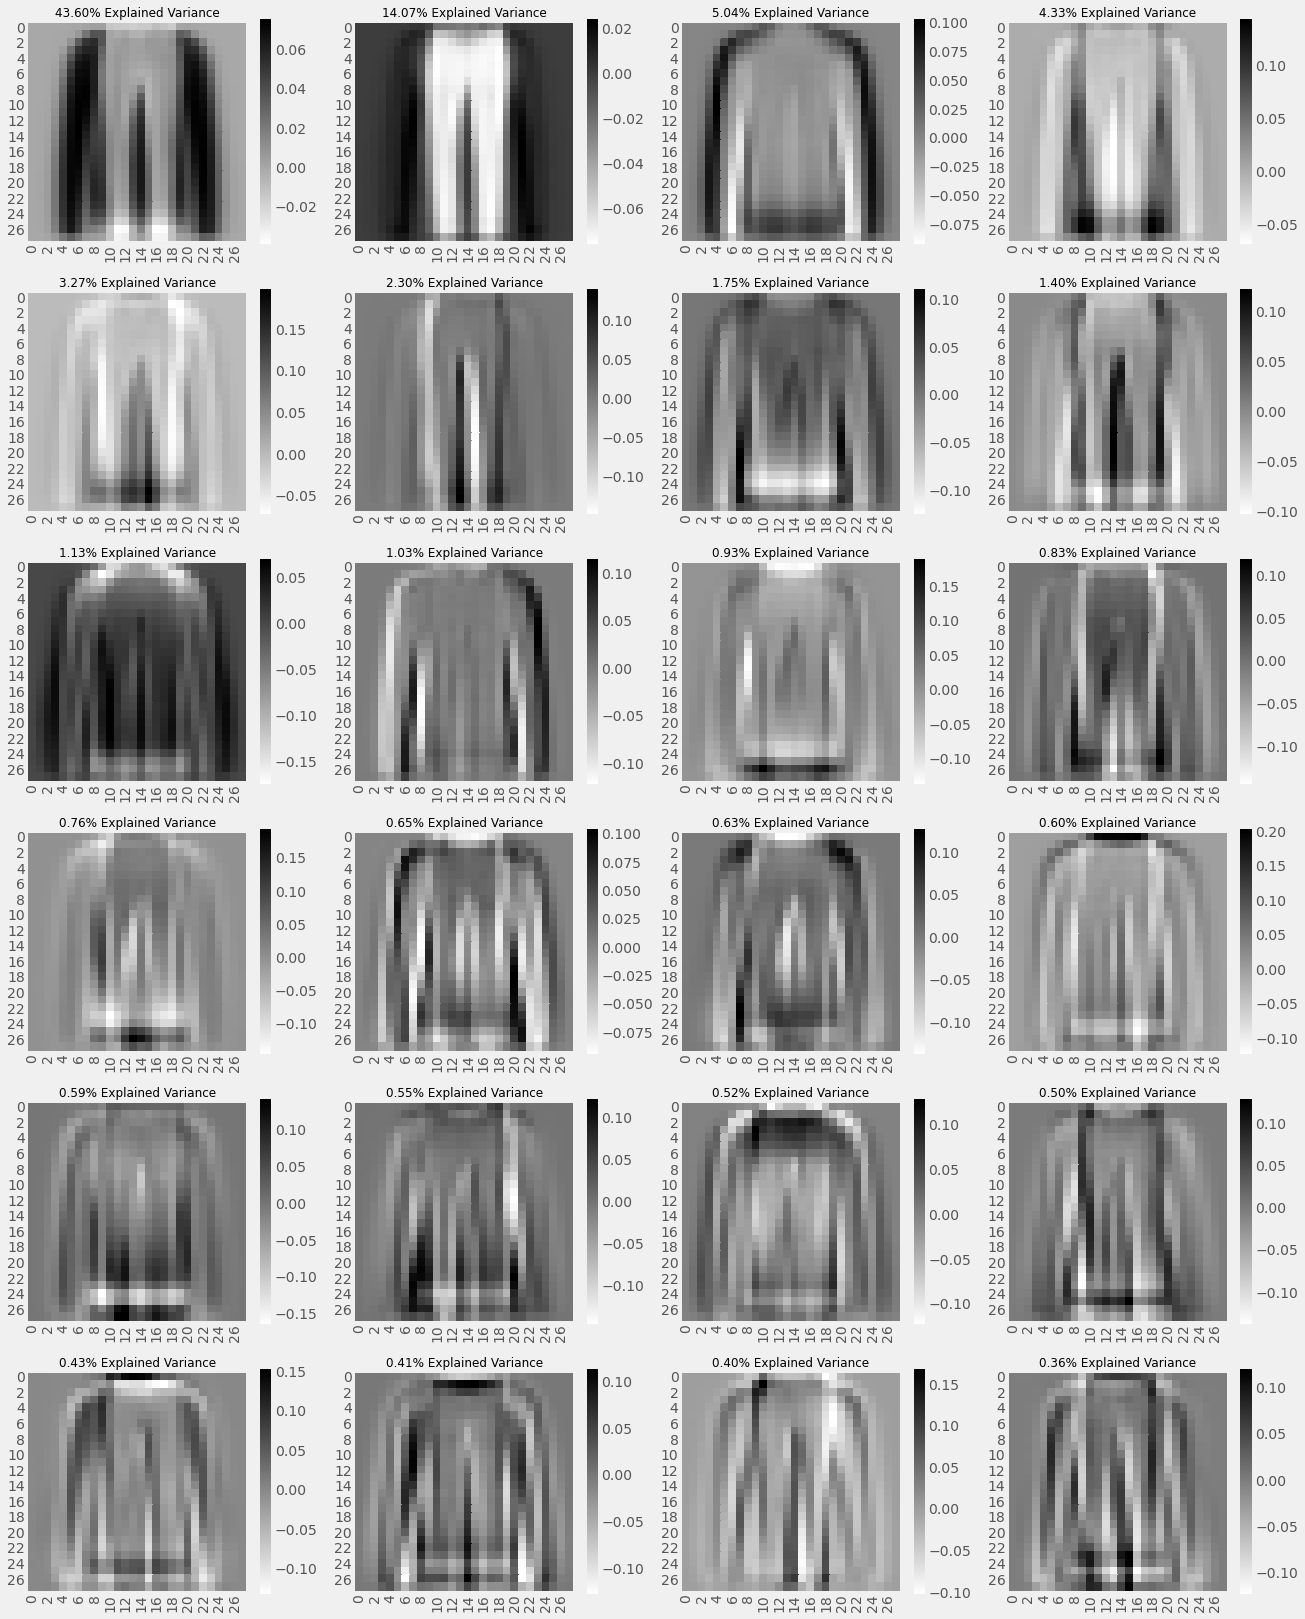

In [21]:
plt.style.use('fivethirtyeight')

fig, axarr = plt.subplots(6, 4, figsize=(20, 27))

sns.heatmap(pca.components_[0, :].reshape(28, 28), ax=axarr[0, 0], cmap='gray_r')
sns.heatmap(pca.components_[1, :].reshape(28, 28), ax=axarr[0, 1], cmap='gray_r')
sns.heatmap(pca.components_[2, :].reshape(28, 28), ax=axarr[0, 2], cmap='gray_r')
sns.heatmap(pca.components_[3, :].reshape(28, 28), ax=axarr[0, 3], cmap='gray_r')
sns.heatmap(pca.components_[4, :].reshape(28, 28), ax=axarr[1, 0], cmap='gray_r')
sns.heatmap(pca.components_[5, :].reshape(28, 28), ax=axarr[1, 1], cmap='gray_r')
sns.heatmap(pca.components_[6, :].reshape(28, 28), ax=axarr[1, 2], cmap='gray_r')
sns.heatmap(pca.components_[7, :].reshape(28, 28), ax=axarr[1, 3], cmap='gray_r')
sns.heatmap(pca.components_[8, :].reshape(28, 28), ax=axarr[2, 0], cmap='gray_r')
sns.heatmap(pca.components_[9, :].reshape(28, 28), ax=axarr[2, 1], cmap='gray_r')
sns.heatmap(pca.components_[10, :].reshape(28, 28), ax=axarr[2, 2], cmap='gray_r')
sns.heatmap(pca.components_[11, :].reshape(28, 28), ax=axarr[2, 3], cmap='gray_r')
sns.heatmap(pca.components_[12, :].reshape(28, 28), ax=axarr[3, 0], cmap='gray_r')
sns.heatmap(pca.components_[13, :].reshape(28, 28), ax=axarr[3, 1], cmap='gray_r')
sns.heatmap(pca.components_[14, :].reshape(28, 28), ax=axarr[3, 2], cmap='gray_r')
sns.heatmap(pca.components_[15, :].reshape(28, 28), ax=axarr[3, 3], cmap='gray_r')
sns.heatmap(pca.components_[16, :].reshape(28, 28), ax=axarr[4, 0], cmap='gray_r')
sns.heatmap(pca.components_[17, :].reshape(28, 28), ax=axarr[4, 1], cmap='gray_r')
sns.heatmap(pca.components_[18, :].reshape(28, 28), ax=axarr[4, 2], cmap='gray_r')
sns.heatmap(pca.components_[19, :].reshape(28, 28), ax=axarr[4, 3], cmap='gray_r')
sns.heatmap(pca.components_[20, :].reshape(28, 28), ax=axarr[5, 0], cmap='gray_r')
sns.heatmap(pca.components_[21, :].reshape(28, 28), ax=axarr[5, 1], cmap='gray_r')
sns.heatmap(pca.components_[22, :].reshape(28, 28), ax=axarr[5, 2], cmap='gray_r')
sns.heatmap(pca.components_[23, :].reshape(28, 28), ax=axarr[5, 3], cmap='gray_r')
axarr[0, 0].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100),fontsize=12)
axarr[0, 1].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100),fontsize=12)
axarr[0, 2].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[2]*100),fontsize=12)
axarr[0, 3].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[3]*100),fontsize=12)
axarr[1, 0].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[4]*100),fontsize=12)
axarr[1, 1].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[5]*100),fontsize=12)
axarr[1, 2].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[6]*100),fontsize=12)
axarr[1, 3].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[7]*100),fontsize=12)
axarr[2, 0].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[8]*100),fontsize=12)
axarr[2, 1].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[9]*100),fontsize=12)
axarr[2, 2].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[10]*100),fontsize=12)
axarr[2, 3].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[11]*100),fontsize=12)
axarr[3, 0].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[12]*100),fontsize=12)
axarr[3, 1].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[13]*100),fontsize=12)
axarr[3, 2].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[14]*100),fontsize=12)
axarr[3, 3].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[15]*100),fontsize=12)
axarr[4, 0].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[16]*100),fontsize=12)
axarr[4, 1].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[17]*100),fontsize=12)
axarr[4, 2].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[18]*100),fontsize=12)
axarr[4, 3].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[19]*100),fontsize=12)
axarr[5, 0].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[20]*100),fontsize=12)
axarr[5, 1].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[21]*100),fontsize=12)
axarr[5, 2].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[22]*100),fontsize=12)
axarr[5, 3].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[23]*100),fontsize=12)
axarr[0, 0].set_aspect('equal'); axarr[0, 1].set_aspect('equal'); axarr[0, 2].set_aspect('equal'); axarr[0, 3].set_aspect('equal')
axarr[1, 0].set_aspect('equal'); axarr[1, 1].set_aspect('equal'); axarr[1, 2].set_aspect('equal'); axarr[1, 3].set_aspect('equal')
axarr[2, 0].set_aspect('equal'); axarr[2, 1].set_aspect('equal'); axarr[2, 2].set_aspect('equal'); axarr[2, 3].set_aspect('equal')
axarr[3, 0].set_aspect('equal'); axarr[3, 1].set_aspect('equal'); axarr[3, 2].set_aspect('equal'); axarr[3, 3].set_aspect('equal')
axarr[4, 0].set_aspect('equal'); axarr[4, 1].set_aspect('equal'); axarr[4, 2].set_aspect('equal'); axarr[4, 3].set_aspect('equal')
axarr[5, 0].set_aspect('equal'); axarr[5, 1].set_aspect('equal'); axarr[5, 2].set_aspect('equal'); axarr[5, 3].set_aspect('equal')

### b) Use the top 24 PCs to reconstruct 30 images, with 15 from each class (any 15 images are fine from each class). Compute and report the mean squared error between the reconstructed and original images for these 30 images (a single value to be reported). Show these 30 pairs of reconstructed and original images. [2 marks]

In [22]:
# Define reconstruction function
def reconstruction(X, n, trans):
    vectors = [trans.components_[n] * X[n] for n in range(0, n)]    
    # Invert the PCA transformation.
    ret = trans.inverse_transform(X)    
    # This process results in non-normal noise on the margins of the data.
    # We clip the results to fit in the [0, 1] interval.
    ret[ret < 0] = 0
    ret[ret > 1] = 1
    return ret

Show 15 pairs of reconstructed and original images of Trousers with the mean squared error between them.

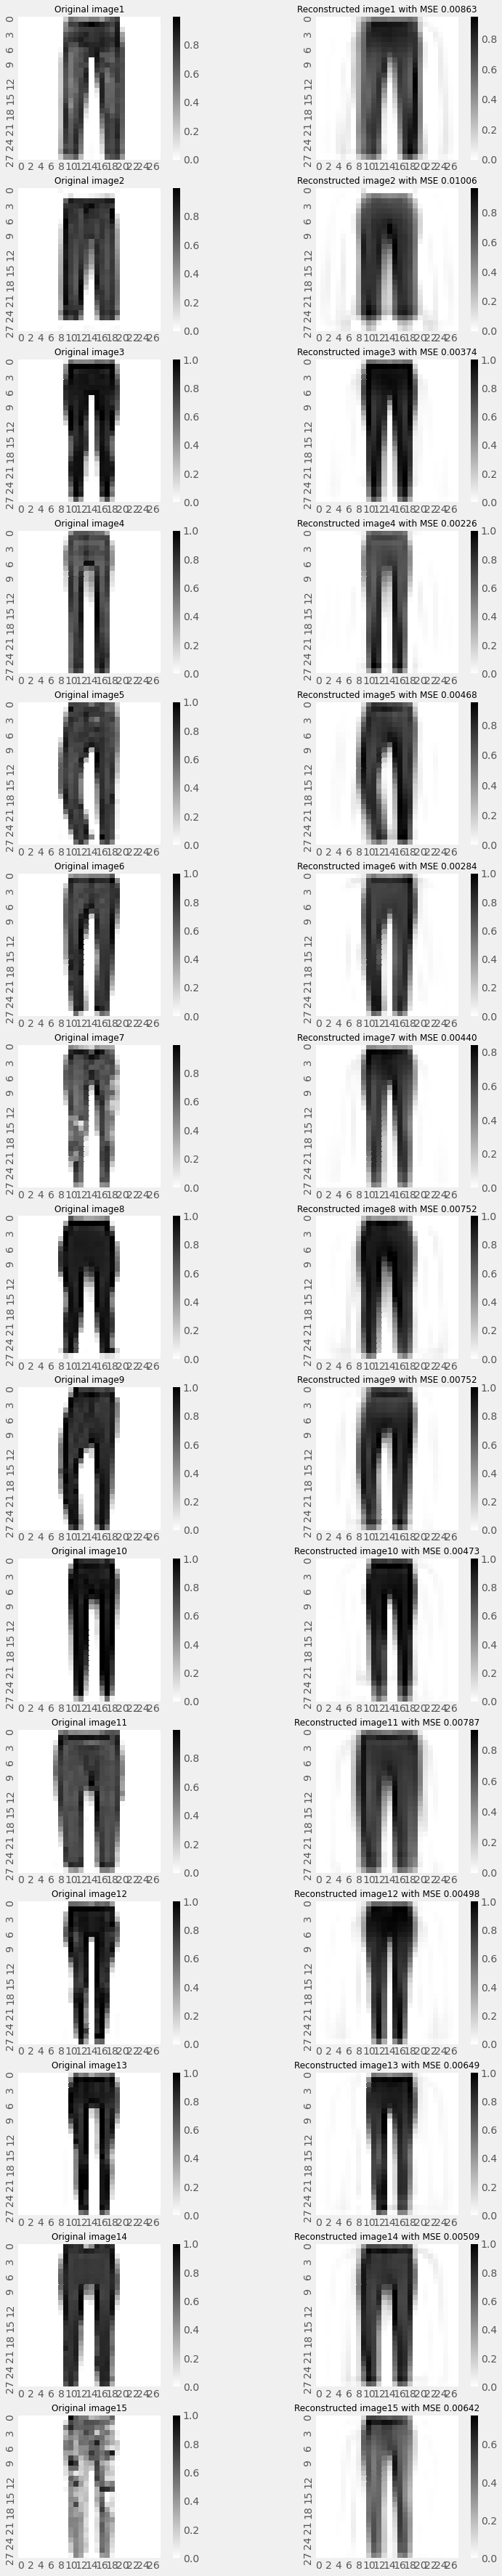

In [23]:
fig, axarr = plt.subplots(15, 2, figsize=(12, 60))

sns.heatmap(input_train_set_features.iloc[2, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[0, 0])
sns.heatmap(reconstruction(input_train_set_features_r[2, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[0, 1])
sns.heatmap(input_train_set_features.iloc[3, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[1, 0])
sns.heatmap(reconstruction(input_train_set_features_r[3, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[1, 1])
sns.heatmap(input_train_set_features.iloc[6, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[2, 0])
sns.heatmap(reconstruction(input_train_set_features_r[6, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[2, 1])
sns.heatmap(input_train_set_features.iloc[11, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[3, 0])
sns.heatmap(reconstruction(input_train_set_features_r[11, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[3, 1])
sns.heatmap(input_train_set_features.iloc[12, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[4, 0])
sns.heatmap(reconstruction(input_train_set_features_r[12, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[4, 1])
sns.heatmap(input_train_set_features.iloc[13, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[5, 0])
sns.heatmap(reconstruction(input_train_set_features_r[13, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[5, 1])
sns.heatmap(input_train_set_features.iloc[14, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[6, 0])
sns.heatmap(reconstruction(input_train_set_features_r[14, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[6, 1])
sns.heatmap(input_train_set_features.iloc[15, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[7, 0])
sns.heatmap(reconstruction(input_train_set_features_r[15, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[7, 1])
sns.heatmap(input_train_set_features.iloc[16, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[8, 0])
sns.heatmap(reconstruction(input_train_set_features_r[16, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[8, 1])
sns.heatmap(input_train_set_features.iloc[18, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[9, 0])
sns.heatmap(reconstruction(input_train_set_features_r[18, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[9, 1])
sns.heatmap(input_train_set_features.iloc[19, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[10, 0])
sns.heatmap(reconstruction(input_train_set_features_r[19, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[10, 1])
sns.heatmap(input_train_set_features.iloc[20, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[11, 0])
sns.heatmap(reconstruction(input_train_set_features_r[20, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[11, 1])
sns.heatmap(input_train_set_features.iloc[21, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[12, 0])
sns.heatmap(reconstruction(input_train_set_features_r[21, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[12, 1])
sns.heatmap(input_train_set_features.iloc[22, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[13, 0])
sns.heatmap(reconstruction(input_train_set_features_r[22, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[13, 1])
sns.heatmap(input_train_set_features.iloc[23, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[14, 0])
sns.heatmap(reconstruction(input_train_set_features_r[23, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[14, 1])

axarr[0, 0].set_title("Original image1", fontsize=12)
axarr[0, 1].set_title("Reconstructed image1 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[2, :].values,
                                         reconstruction(input_train_set_features_r[2, :], 24, pca))), fontsize=12)
axarr[1, 0].set_title("Original image2", fontsize=12)
axarr[1, 1].set_title("Reconstructed image2 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[3, :].values,
                                         reconstruction(input_train_set_features_r[3, :], 24, pca))), fontsize=12)
axarr[2, 0].set_title("Original image3", fontsize=12)
axarr[2, 1].set_title("Reconstructed image3 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[6, :].values,
                                         reconstruction(input_train_set_features_r[6, :], 24, pca))), fontsize=12)
axarr[3, 0].set_title("Original image4", fontsize=12)
axarr[3, 1].set_title("Reconstructed image4 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[11, :].values,
                                         reconstruction(input_train_set_features_r[11, :], 24, pca))), fontsize=12)
axarr[4, 0].set_title("Original image5", fontsize=12)
axarr[4, 1].set_title("Reconstructed image5 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[12, :].values,
                                         reconstruction(input_train_set_features_r[12, :], 24, pca))), fontsize=12)
axarr[5, 0].set_title("Original image6", fontsize=12)
axarr[5, 1].set_title("Reconstructed image6 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[13, :].values,
                                         reconstruction(input_train_set_features_r[13, :], 24, pca))), fontsize=12)
axarr[6, 0].set_title("Original image7", fontsize=12)
axarr[6, 1].set_title("Reconstructed image7 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[14, :].values,
                                         reconstruction(input_train_set_features_r[14, :], 24, pca))), fontsize=12)
axarr[7, 0].set_title("Original image8", fontsize=12)
axarr[7, 1].set_title("Reconstructed image8 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[15, :].values,
                                         reconstruction(input_train_set_features_r[15, :], 24, pca))), fontsize=12)
axarr[8, 0].set_title("Original image9", fontsize=12)
axarr[8, 1].set_title("Reconstructed image9 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[16, :].values,
                                         reconstruction(input_train_set_features_r[16, :], 24, pca))), fontsize=12)
axarr[9, 0].set_title("Original image10", fontsize=12)
axarr[9, 1].set_title("Reconstructed image10 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[18, :].values,
                                         reconstruction(input_train_set_features_r[18, :], 24, pca))), fontsize=12)
axarr[10, 0].set_title("Original image11", fontsize=12)
axarr[10, 1].set_title("Reconstructed image11 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[19, :].values,
                                         reconstruction(input_train_set_features_r[19, :], 24, pca))), fontsize=12)
axarr[11, 0].set_title("Original image12", fontsize=12)
axarr[11, 1].set_title("Reconstructed image12 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[20, :].values,
                                         reconstruction(input_train_set_features_r[20, :], 24, pca))), fontsize=12)
axarr[12, 0].set_title("Original image13", fontsize=12)
axarr[12, 1].set_title("Reconstructed image13 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[21, :].values,
                                         reconstruction(input_train_set_features_r[21, :], 24, pca))), fontsize=12)
axarr[13, 0].set_title("Original image14", fontsize=12)
axarr[13, 1].set_title("Reconstructed image14 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[22, :].values,
                                         reconstruction(input_train_set_features_r[22, :], 24, pca))), fontsize=12)
axarr[14, 0].set_title("Original image15", fontsize=12)
axarr[14, 1].set_title("Reconstructed image15 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[23, :].values,
                                         reconstruction(input_train_set_features_r[23, :], 24, pca))), fontsize=12)

axarr[0, 0].set_aspect('equal'); axarr[0, 1].set_aspect('equal'); axarr[1, 0].set_aspect('equal'); axarr[1, 1].set_aspect('equal')
axarr[2, 0].set_aspect('equal'); axarr[2, 1].set_aspect('equal'); axarr[3, 0].set_aspect('equal'); axarr[3, 1].set_aspect('equal')
axarr[4, 0].set_aspect('equal'); axarr[4, 1].set_aspect('equal'); axarr[5, 0].set_aspect('equal'); axarr[5, 1].set_aspect('equal')
axarr[6, 0].set_aspect('equal'); axarr[6, 1].set_aspect('equal'); axarr[7, 0].set_aspect('equal'); axarr[7, 1].set_aspect('equal')
axarr[8, 0].set_aspect('equal'); axarr[8, 1].set_aspect('equal'); axarr[9, 0].set_aspect('equal'); axarr[9, 1].set_aspect('equal')
axarr[10, 0].set_aspect('equal'); axarr[10, 1].set_aspect('equal'); axarr[11, 0].set_aspect('equal'); axarr[11, 1].set_aspect('equal')
axarr[12, 0].set_aspect('equal'); axarr[12, 1].set_aspect('equal'); axarr[13, 0].set_aspect('equal'); axarr[13, 1].set_aspect('equal')
axarr[14, 0].set_aspect('equal'); axarr[14, 1].set_aspect('equal');

Show 15 pairs of reconstructed and original images of Pullovers with the mean squared error between them.

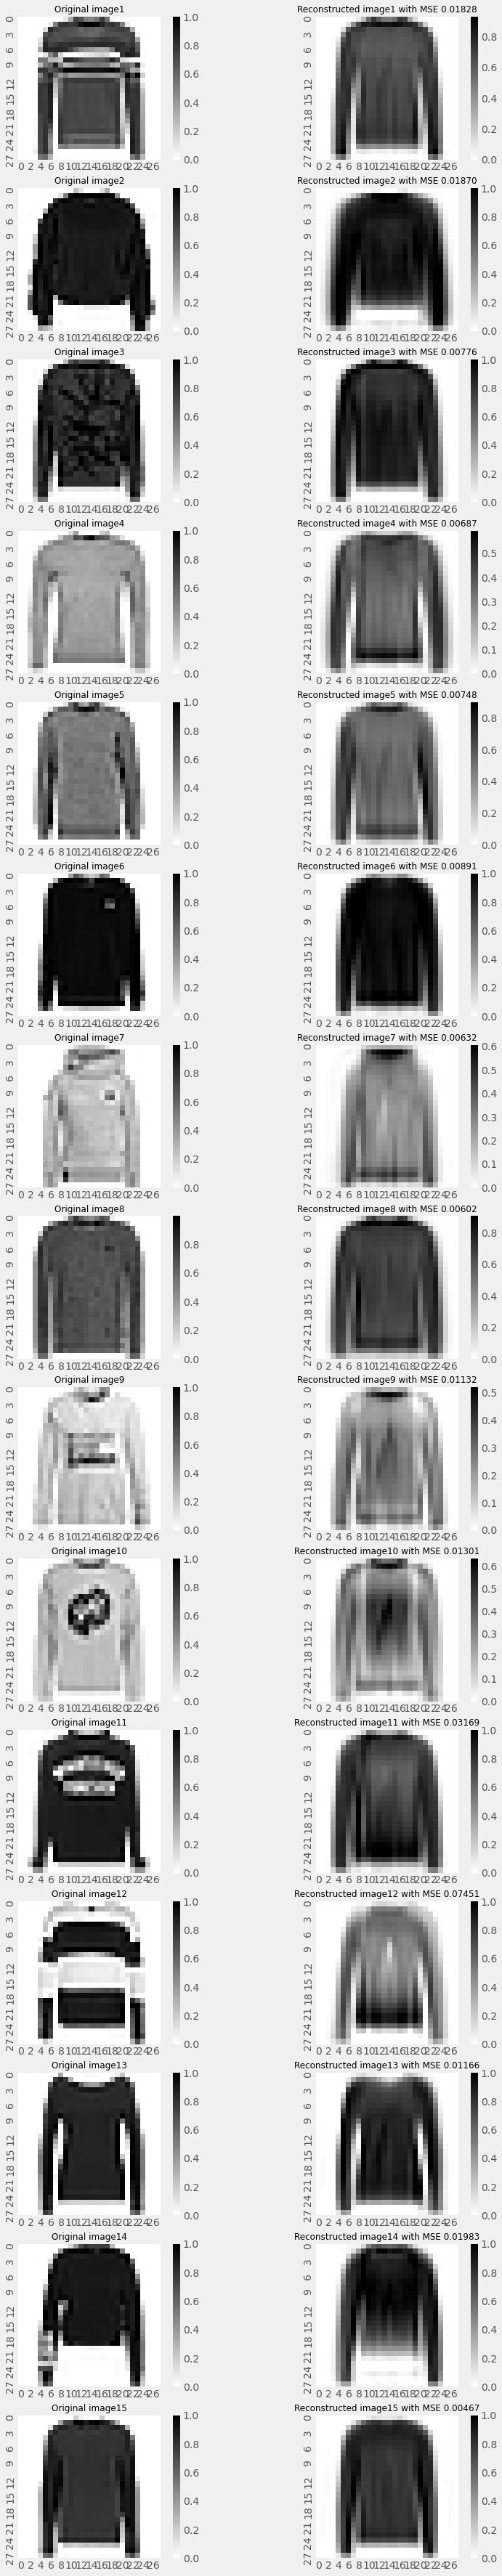

In [24]:
fig, axarr = plt.subplots(15, 2, figsize=(12, 60))

sns.heatmap(input_train_set_features.iloc[0, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[0, 0])
sns.heatmap(reconstruction(input_train_set_features_r[0, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[0, 1])
sns.heatmap(input_train_set_features.iloc[1, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[1, 0])
sns.heatmap(reconstruction(input_train_set_features_r[1, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[1, 1])
sns.heatmap(input_train_set_features.iloc[4, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[2, 0])
sns.heatmap(reconstruction(input_train_set_features_r[4, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[2, 1])
sns.heatmap(input_train_set_features.iloc[5, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[3, 0])
sns.heatmap(reconstruction(input_train_set_features_r[5, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[3, 1])
sns.heatmap(input_train_set_features.iloc[7, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[4, 0])
sns.heatmap(reconstruction(input_train_set_features_r[7, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[4, 1])
sns.heatmap(input_train_set_features.iloc[8, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[5, 0])
sns.heatmap(reconstruction(input_train_set_features_r[8, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[5, 1])
sns.heatmap(input_train_set_features.iloc[9, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[6, 0])
sns.heatmap(reconstruction(input_train_set_features_r[9, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[6, 1])
sns.heatmap(input_train_set_features.iloc[10, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[7, 0])
sns.heatmap(reconstruction(input_train_set_features_r[10, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[7, 1])
sns.heatmap(input_train_set_features.iloc[17, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[8, 0])
sns.heatmap(reconstruction(input_train_set_features_r[17, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[8, 1])
sns.heatmap(input_train_set_features.iloc[24, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[9, 0])
sns.heatmap(reconstruction(input_train_set_features_r[24, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[9, 1])
sns.heatmap(input_train_set_features.iloc[25, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[10, 0])
sns.heatmap(reconstruction(input_train_set_features_r[25, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[10, 1])
sns.heatmap(input_train_set_features.iloc[26, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[11, 0])
sns.heatmap(reconstruction(input_train_set_features_r[26, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[11, 1])
sns.heatmap(input_train_set_features.iloc[28, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[12, 0])
sns.heatmap(reconstruction(input_train_set_features_r[28, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[12, 1])
sns.heatmap(input_train_set_features.iloc[32, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[13, 0])
sns.heatmap(reconstruction(input_train_set_features_r[32, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[13, 1])
sns.heatmap(input_train_set_features.iloc[34, :].values.reshape(28, 28), cmap='gray_r', ax=axarr[14, 0])
sns.heatmap(reconstruction(input_train_set_features_r[34, :], 24, pca).reshape(28, 28), cmap='gray_r',ax=axarr[14, 1])

axarr[0, 0].set_title("Original image1", fontsize=12)
axarr[0, 1].set_title("Reconstructed image1 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[0, :].values,
                                         reconstruction(input_train_set_features_r[0, :], 24, pca))), fontsize=12)
axarr[1, 0].set_title("Original image2", fontsize=12)
axarr[1, 1].set_title("Reconstructed image2 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[1, :].values,
                                         reconstruction(input_train_set_features_r[1, :], 24, pca))), fontsize=12)
axarr[2, 0].set_title("Original image3", fontsize=12)
axarr[2, 1].set_title("Reconstructed image3 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[4, :].values,
                                         reconstruction(input_train_set_features_r[4, :], 24, pca))), fontsize=12)
axarr[3, 0].set_title("Original image4", fontsize=12)
axarr[3, 1].set_title("Reconstructed image4 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[5, :].values,
                                         reconstruction(input_train_set_features_r[5, :], 24, pca))), fontsize=12)
axarr[4, 0].set_title("Original image5", fontsize=12)
axarr[4, 1].set_title("Reconstructed image5 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[7, :].values,
                                         reconstruction(input_train_set_features_r[7, :], 24, pca))), fontsize=12)
axarr[5, 0].set_title("Original image6", fontsize=12)
axarr[5, 1].set_title("Reconstructed image6 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[8, :].values,
                                         reconstruction(input_train_set_features_r[8, :], 24, pca))), fontsize=12)
axarr[6, 0].set_title("Original image7", fontsize=12)
axarr[6, 1].set_title("Reconstructed image7 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[9, :].values,
                                         reconstruction(input_train_set_features_r[9, :], 24, pca))), fontsize=12)
axarr[7, 0].set_title("Original image8", fontsize=12)
axarr[7, 1].set_title("Reconstructed image8 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[10, :].values,
                                         reconstruction(input_train_set_features_r[10, :], 24, pca))), fontsize=12)
axarr[8, 0].set_title("Original image9", fontsize=12)
axarr[8, 1].set_title("Reconstructed image9 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[17, :].values,
                                         reconstruction(input_train_set_features_r[17, :], 24, pca))), fontsize=12)
axarr[9, 0].set_title("Original image10", fontsize=12)
axarr[9, 1].set_title("Reconstructed image10 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[24, :].values,
                                         reconstruction(input_train_set_features_r[24, :], 24, pca))), fontsize=12)
axarr[10, 0].set_title("Original image11", fontsize=12)
axarr[10, 1].set_title("Reconstructed image11 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[25, :].values,
                                         reconstruction(input_train_set_features_r[25, :], 24, pca))), fontsize=12)
axarr[11, 0].set_title("Original image12", fontsize=12)
axarr[11, 1].set_title("Reconstructed image12 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[26, :].values,
                                         reconstruction(input_train_set_features_r[26, :], 24, pca))), fontsize=12)
axarr[12, 0].set_title("Original image13", fontsize=12)
axarr[12, 1].set_title("Reconstructed image13 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[28, :].values,
                                         reconstruction(input_train_set_features_r[28, :], 24, pca))), fontsize=12)
axarr[13, 0].set_title("Original image14", fontsize=12)
axarr[13, 1].set_title("Reconstructed image14 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[32, :].values,
                                         reconstruction(input_train_set_features_r[32, :], 24, pca))), fontsize=12)
axarr[14, 0].set_title("Original image15", fontsize=12)
axarr[14, 1].set_title("Reconstructed image15 with MSE {0:.5f}".format(mean_squared_error(input_train_set_features.iloc[34, :].values,
                                         reconstruction(input_train_set_features_r[34, :], 24, pca))), fontsize=12)

axarr[0, 0].set_aspect('equal'); axarr[0, 1].set_aspect('equal'); axarr[1, 0].set_aspect('equal'); axarr[1, 1].set_aspect('equal')
axarr[2, 0].set_aspect('equal'); axarr[2, 1].set_aspect('equal'); axarr[3, 0].set_aspect('equal'); axarr[3, 1].set_aspect('equal')
axarr[4, 0].set_aspect('equal'); axarr[4, 1].set_aspect('equal'); axarr[5, 0].set_aspect('equal'); axarr[5, 1].set_aspect('equal')
axarr[6, 0].set_aspect('equal'); axarr[6, 1].set_aspect('equal'); axarr[7, 0].set_aspect('equal'); axarr[7, 1].set_aspect('equal')
axarr[8, 0].set_aspect('equal'); axarr[8, 1].set_aspect('equal'); axarr[9, 0].set_aspect('equal'); axarr[9, 1].set_aspect('equal')
axarr[10, 0].set_aspect('equal'); axarr[10, 1].set_aspect('equal'); axarr[11, 0].set_aspect('equal'); axarr[11, 1].set_aspect('equal')
axarr[12, 0].set_aspect('equal'); axarr[12, 1].set_aspect('equal'); axarr[13, 0].set_aspect('equal'); axarr[13, 1].set_aspect('equal')
axarr[14, 0].set_aspect('equal'); axarr[14, 1].set_aspect('equal');

### c) Plot the PCA representations of all data points in a 2D plane using the top two PCs. Use different colours/markers for the two classes for better visualisation ( Hint: You need to use the class labels here for visualisation ). [2 marks]

I Append the real label name and the top two PCs' values as columns to the training set, naming them "label name", "First Dimension", "Second Dimension".

In [25]:
train_set_23c = train_set_2class
results = []
# Loop through all labels
for i in range(train_set_23c.shape[0]):
    # Extract the labels for comparison
    if train_set_23c.iloc[i, -1] == 1:
        results.append('Trouser')
    elif train_set_23c.iloc[i, -1] == 2:
        results.append('Pullover')

df_results = pd.DataFrame(results)
# Name the new colunmn name
df_results = df_results.rename(columns={0 : "label name"})  
# Reset the index for concat later
train_set_2class.reset_index(drop=True, inplace=True)
train_set_23c = pd.concat([train_set_2class, df_results], axis = 1)
# Name the new name of two columns
train_set_23c['First Dimension'] = input_train_set_features_r[:,0]
train_set_23c['Second Dimension'] = input_train_set_features_r[:,1]
# Normalizing the features
x1 = train_set_23c.iloc[:, 0:784]/255
x2 = train_set_23c.iloc[:, 784:788]
train_set_23c = pd.concat([x1, x2], axis = 1)
train_set_23c

,0,1,2,3,4,5,6,7,8,9,...,778,779,780,781,782,783,label,label name,First Dimension,Second Dimension
0,0.0,0.0,0.0,0.000000,0.003922,0.000000,0.000000,0.0,0.000000,0.086275,...,0.521569,0.654902,0.286275,0.00000,0.0,0.0,2,Pullover,5.692467,0.394633
1,0.0,0.0,0.0,0.000000,0.000000,0.003922,0.003922,0.0,0.000000,0.000000,...,0.321569,0.929412,0.905882,0.27451,0.0,0.0,2,Pullover,9.708331,-1.268580
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.207843,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,1,Trouser,-2.626545,-1.465335
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.035294,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,1,Trouser,-2.940076,-1.914716
4,0.0,0.0,0.0,0.003922,0.000000,0.000000,0.000000,0.0,0.000000,0.274510,...,0.619608,0.576471,0.000000,0.00000,0.0,0.0,2,Pullover,9.039110,-1.758767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,0.0,0.0,0.000000,0.003922,0.000000,0.000000,0.0,0.133333,0.403922,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,2,Pullover,7.524521,-4.039579
11996,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,1,Trouser,-4.951953,0.074731
11997,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,1,Trouser,-5.333770,-0.450021
11998,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.243137,0.000000,0.000000,0.00000,0.0,0.0,2,Pullover,0.220207,2.287929


Then finish plot.

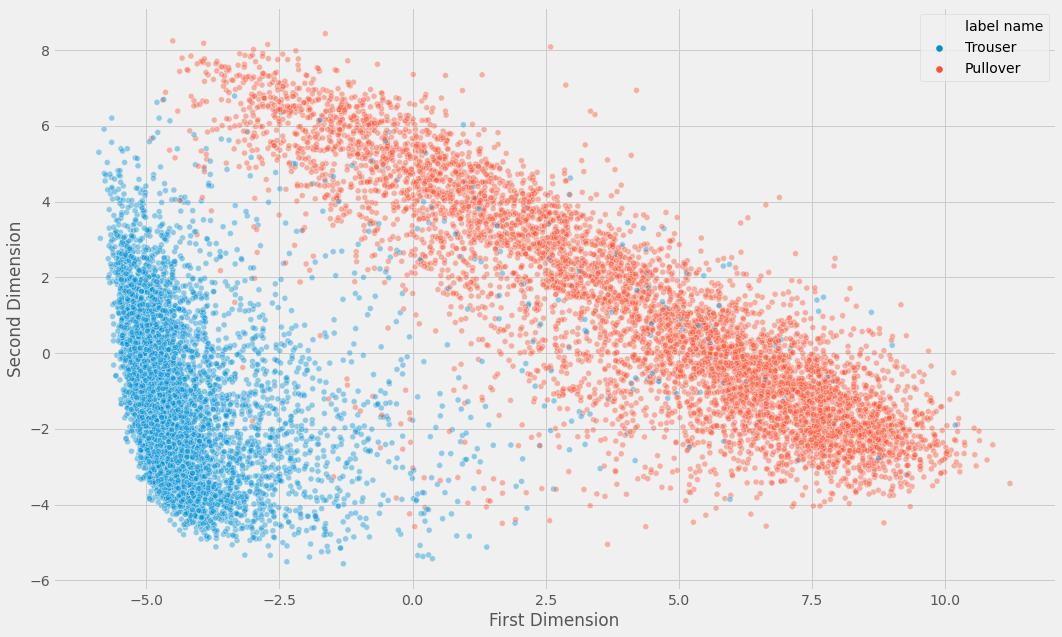

In [26]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="First Dimension", y="Second Dimension",
    hue = "label name",
    hue_order = ['Trouser', 'Pullover'],
    data=train_set_23c,
    alpha=0.4 
)

### d) Use k -means to cluster all data points as represented by the top two PCs (clustering of two-dimensional vectors, where each vector has two values, PC1 and PC2). Visualise the two clusters with different colours/markers and indicate the cluster centers clearly with a marker in a figure similar to question c) above. [1 mark].

Left purple area represents Trousers, right yellow area represents Pullovers


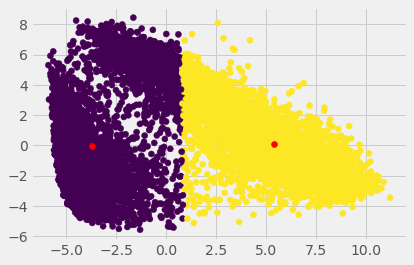

In [27]:
# Get top 2 PCs
pca31d = PCA(n_components = 2)
input_train_set_features_r_31d = pca31d.fit(input_train_set_features).transform(input_train_set_features)
# Use k-means to cluster all data points
random_state = 729
kmeans = KMeans(n_clusters=2, random_state = random_state)
kmeans.fit(input_train_set_features_r_31d)
pred_31d = kmeans.predict(input_train_set_features_r_31d)
# Visualise the two clusters with different colours/markers and indicate the cluster centers(red pot) clearly with a marker
plt.scatter(input_train_set_features_r_31d[:, 0], input_train_set_features_r_31d[:, 1], c = pred_31d, cmap = 'viridis')
centers = kmeans.cluster_centers_
print("Left purple area represents Trousers, right yellow area represents Pullovers")
plt.scatter(centers[:, 0], centers[:, 1], c = 'red');

### B3.2 AutoEncoder [4 marks]

First, I prepare the training set for Autoencoder.

In [28]:
trainset_b32 = trainset
# Get indexes of all Trousers and Pullovers.
idx = (trainset_b32.targets == 1) | (trainset_b32.targets == 2)
trainset_b32.targets = trainset_b32.targets[idx]
trainset_b32.data = trainset_b32.data[idx]

#### a) Design a new autoencoder with five Conv2d layers and five ConvTranspose2d layers. You are free to choose the activation functions and settings such as stride and padding. Train this new autoencoder on all images of these two chosen classes for at least 20 epochs. Plot the mean squared error against the epoch. [2 marks]

In [29]:
# Create the Autoencoder module for a)
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 784, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(784, 128, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
# Use GPU to train    
myAE=Autoencoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myAE.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 784, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(784, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)

Train this autoencoder on all images of two chosen classes for 20 epochs.

In [30]:
#Training parameters
batch_size_b32 = 512
learning_rate_b32 = 1e-3
max_epochs_b32 = 20
#Choose mean square error loss
criterion_b32 = nn.MSELoss() 
#Choose the Adam optimiser
optimizer_b32 = torch.optim.Adam(myAE.parameters(), lr = learning_rate_b32, weight_decay = 1e-5)
train_loader_b32 = torch.utils.data.DataLoader(trainset_b32, batch_size = batch_size_b32, shuffle = True)
outputs_b32 = []
all_loss_b32 = []
index_b32 = []
#Start training
for epoch in range(max_epochs_b32):
    for data_b32 in train_loader_b32:
        img_b32, label_b32 = data_b32
        img_b32 = img_b32.to(device)
        label_b32 = label_b32.to(device)
        optimizer_b32.zero_grad()
        recon_b32 = myAE(img_b32)
        loss_b32 = criterion_b32(recon_b32, img_b32)
        loss_b32.backward()
        optimizer_b32.step()            
    if (epoch % 1) == 0:
        print('Epoch:{}, MSELoss:{:.4f}'.format(epoch + 1, float(loss_b32)))
        all_loss_b32.append(float(loss_b32))
        index_b32.append(int(epoch + 1))
    outputs_b32.append((epoch, img_b32, recon_b32),)

Epoch:1, MSELoss:0.2723
Epoch:2, MSELoss:0.1327
Epoch:3, MSELoss:0.0876
Epoch:4, MSELoss:0.0620
Epoch:5, MSELoss:0.0460
Epoch:6, MSELoss:0.0392
Epoch:7, MSELoss:0.0371
Epoch:8, MSELoss:0.0278
Epoch:9, MSELoss:0.0266
Epoch:10, MSELoss:0.0217
Epoch:11, MSELoss:0.0197
Epoch:12, MSELoss:0.0171
Epoch:13, MSELoss:0.0186
Epoch:14, MSELoss:0.0165
Epoch:15, MSELoss:0.0157
Epoch:16, MSELoss:0.0136
Epoch:17, MSELoss:0.0160
Epoch:18, MSELoss:0.0133
Epoch:19, MSELoss:0.0104
Epoch:20, MSELoss:0.0113


Plot the mean squared error against the epoch.

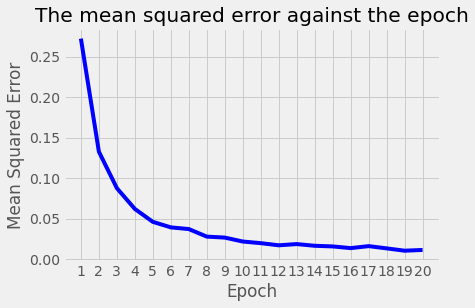

In [31]:
x_pos_b32 = [i for i, _ in enumerate(index_b32)]
plt.plot(x_pos_b32, all_loss_b32, color='blue')
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("The mean squared error against the epoch")
#Set the current tick locations and labels of the x-axis.
plt.xticks(x_pos_b32, index_b32)
plt.show()

#### b) Modify the autoencoder in 3.2a so that the code (bottleneck) has a dimension of 2 only. Plot the 2-dimensional representations in terms of this autoencoder code for all data points in a 2D plane as in 3.1c and cluster them as in 3.1d, showing similar colour/marker visualisation. [2 marks]

In [32]:
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 16, 7),
            nn.ReLU(),
            nn.Conv2d(16, 32, 7),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),
            nn.ReLU(),
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),
            nn.Conv2d(128, 2, 4)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2, 128, 4),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 7),
            nn.Sigmoid()
        )
    def forward(self, x):
        # The program only runs the encode part
        x = self.encoder(x)
        return x
myAE2=Autoencoder2()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myAE2.to(device)    

Autoencoder2(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 2, kernel_size=(4, 4), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(2, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 16, kernel_size=(7, 7), stride=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(16, 1, kernel_size=(7, 7), stride=(1, 1))
    (9): Sigmoid()
  )
)

In [33]:
#Train model
batch_size_b32b = 12000
learning_rate_b32b = 1e-4
max_epochs_b32b = 20
criterion_b32b = nn.MSELoss() 
optimizer_b32b = torch.optim.Adam(myAE2.parameters(), lr = learning_rate_b32b, weight_decay = 1e-5)
train_loader_b32b = torch.utils.data.DataLoader(trainset_b32, batch_size = batch_size_b32b, shuffle = True)
# outputs_b32b = []
for epoch in range(max_epochs_b32b):
    for data_b32b in train_loader_b32b:
        img_b32b, label_b32b = data_b32b
        img_b32b = img_b32b.to(device)
        label_b32b = label_b32b.to(device)
        optimizer_b32b.zero_grad()
        recon_b32b = myAE2(img_b32b)
        loss_b32b = criterion_b32b(recon_b32b, img_b32b)
        loss_b32b.backward()
        optimizer_b32b.step()            
#     if (epoch % 1) == 0:
#         print('Epoch:{}, MSELoss:{:.4f}'.format(epoch + 1, float(loss_b32b)))
#     outputs_b32b.append((epoch, img_b32b, recon_b32b),)

D:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([12000, 1, 28, 28])) that is different to the input size (torch.Size([12000, 2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [34]:
# Append the 2-dimensional representations in terms of this autoencoder as columns to the training set, 
# naming them "First Dimension", "Second Dimension".
recon_b32b_array = recon_b32b.cpu().data.numpy()
recon_b32b_array2d = recon_b32b_array.reshape(12000,2)
train_set_32b = pd.concat([train_set_2class, df_results], axis = 1)
train_set_32b['First Dimension'] = recon_b32b_array2d[:,0]
train_set_32b['Second Dimension'] = recon_b32b_array2d[:,1]
x1 = train_set_32b.iloc[:, 0:784]/255
x2 = train_set_32b.iloc[:, 784:788]
train_set_32b = pd.concat([x1, x2], axis = 1)
train_set_32b

,0,1,2,3,4,5,6,7,8,9,...,778,779,780,781,782,783,label,label name,First Dimension,Second Dimension
0,0.0,0.0,0.0,0.000000,0.003922,0.000000,0.000000,0.0,0.000000,0.086275,...,0.521569,0.654902,0.286275,0.00000,0.0,0.0,2,Pullover,-0.525938,-0.526194
1,0.0,0.0,0.0,0.000000,0.000000,0.003922,0.003922,0.0,0.000000,0.000000,...,0.321569,0.929412,0.905882,0.27451,0.0,0.0,2,Pullover,-0.517506,-0.528503
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.207843,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,1,Trouser,-0.054752,-0.066037
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.035294,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,1,Trouser,-0.064178,-0.075216
4,0.0,0.0,0.0,0.003922,0.000000,0.000000,0.000000,0.0,0.000000,0.274510,...,0.619608,0.576471,0.000000,0.00000,0.0,0.0,2,Pullover,-0.538306,-0.574490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,0.0,0.0,0.000000,0.003922,0.000000,0.000000,0.0,0.133333,0.403922,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,2,Pullover,-0.047072,-0.056698
11996,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,1,Trouser,-0.201357,-0.202108
11997,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,1,Trouser,-0.193623,-0.214519
11998,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.243137,0.000000,0.000000,0.00000,0.0,0.0,2,Pullover,-0.355746,-0.374310


Plot the 2-dimensional representations in terms of this autoencoder code for all data points in a 2D plane.

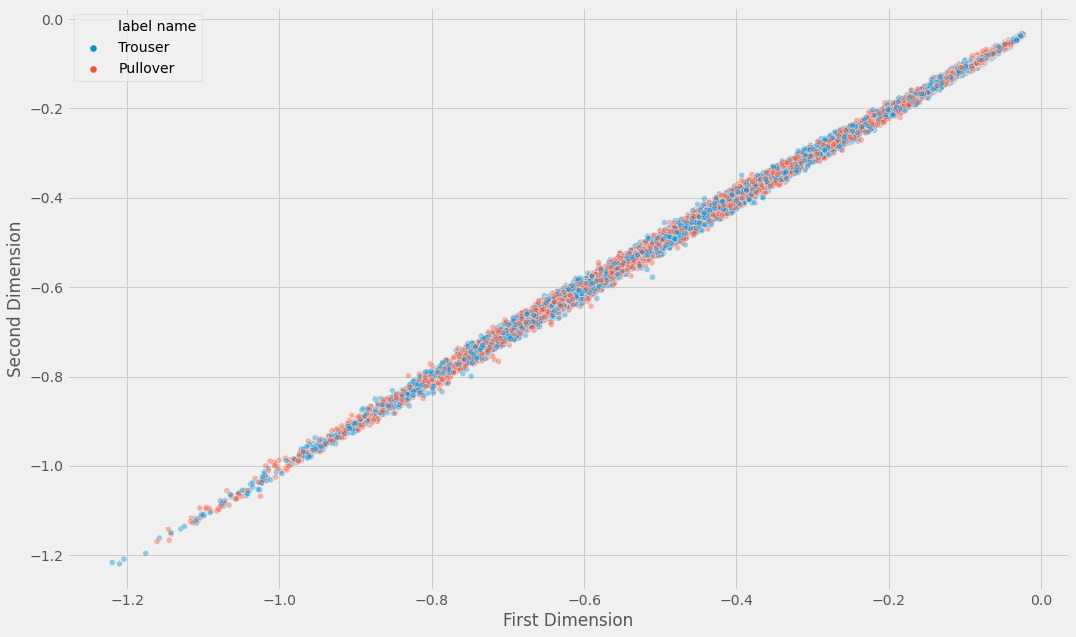

In [35]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="First Dimension", y="Second Dimension",
    hue = "label name",
    hue_order = ['Trouser', 'Pullover'],
    data=train_set_32b,
    alpha=0.4 
)

Cluster them, showing similar colour/marker visualisation.

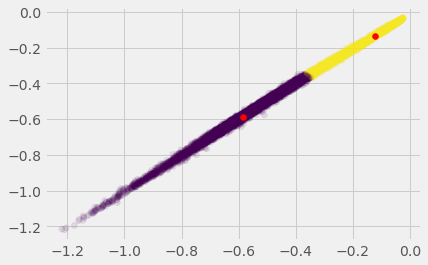

In [36]:
recon_b32b_array2d = np.array(recon_b32b_array2d, dtype = "float64")
random_state = 729
kmeans_32b = KMeans(n_clusters = 2, random_state = random_state)
kmeans_32b.fit(recon_b32b_array2d)
pred_32b = kmeans_32b.predict(recon_b32b_array2d)


plt.scatter(recon_b32b_array2d[:, 0], recon_b32b_array2d[:, 1], c = pred_32b, cmap = 'viridis', alpha = 0.1)
centers_32b = kmeans_32b.cluster_centers_
plt.scatter(centers_32b[:, 0], centers_32b[:, 1], c = 'red');

### B3.3 Observation [1 marks]
#### Describe at least two observations interesting to you from B3.1 and B3.2 above.

1. Result of visualisation of the top 24 eigenvectors in B3.1a) shows that the first two components explain the majority of the variance in the data.
2. In the process of reconstructing the images, the larger the MSE, the greater the difference between the reconstructed images and the original images.
3. Plot of visualisation of the top two PCs' data point in B3.1c) shows two clearly distinguishable clusters, and this is confirmed by k-means clustering in B3.1b)
4. In this assignment, all neural nets are trained with different forms of stochastic gradient decent. Generally speaking, too small batchsize will lead to inaccurate declining direction, which will cause fluctuations in loss(MSE).